# 1D Helmholtz Equation with  *p*-FEM 

Author: [Hadrien Bériot](https://scholar.google.be/citations?user=4UYi8QMAAAAJ&hl=fr)

This notebook is intended as a brief introduction to high-order finite elements (or *p*-FEM) for time-harmonic acoustics. Approximation theory indicates that when approaching [smooth functions](https://en.wikipedia.org/wiki/Smoothness) (i.e. which do not contain singularities) higher-order polynomials do a much better job for a fixed number of coefficients.
Solutions of Helmholtz problems are *mostly* smooth, as they are composed (in the vast majority of cases) of sine and cosine functions. Hence, higher-order approximation is in general **strongly beneficial** for acoustic applications. 

A simple one-dimensional Helmholtz problem is presented here and solved using high-order (hierarchic) shape functions. The numerical results may be interactively obtained for varying order *p*, mesh size *h* at a given frequency $\omega$. This allows to highlight the superiority of *p*-refinement (increasing the order) over *h*-refinement (decreasing the mesh size). 
    

## Prerequisites
In order to be able to run the code presented in this tutorial you will need just the very basics, as it is pretty much self contained:

- A working Python environment for your platform. For more information, refer to the [Python website](https://www.python.org/);
- The following Python packages installed in your environment:
    - numpy;
    - math; 
    - matplotlib;

A basic knowledge of Partial Differential Equations (PDEs) and FEM will of course be beneficial. 

Also, if you are using a dark theme in your browser, just uncomment the line "plt.style.use('dark_background')" in the code below. 

## Problem description
We propose here to examine the acoustic propagation in a straight one-dimensional duct. A piston is vibrating with a given velocity at the inlet and an absorbing material is used at the outlet.  
- Domain $x \in [0,L]$
- Piston vibrating at $x=0$ (normal velocity $\bar{V}_n$)
- Absorbing material at $x=L$ (admittance $\bar{\beta}$)

<img src="piston.png" style="width:600px">

This could correspond to a Kundt's tube, or more prosaically, to someone playing the didjeridoo :)

<img src="didjeridoo.png" style="width:400px">

We consider the propagation of harmonic, linear sound waves in a uniform, quiescent medium. The complex amplitude of the acoustic pressure $u(x)$ in the duct is governed by the Helmholtz scalar equation:

$\Delta u + k^2 u = 0$ in $\Omega$

$\frac{\partial u}{\partial n} = -i\omega \rho_0 \bar{V}_n$ at  $x=0$ (Neumann BC = enforced acoustic normal velocity $\bar{V}_n$)

$\frac{\partial u}{\partial n}+ i k \bar{\beta} u = 0 $ at $x=L$ (Robin BC = enforced admitance/impedance $\bar{\beta}$)

where $k=\omega/c_0$ is the acoustic wavenumber (with $c_0$ the sound speed), $\rho_0$ is the density and $\beta$ is the normalized admittance of the acoustic liner/treatment. 
Note that by convention the normal here is pointing outside the domain, meaning $n=-x$ at $x=0$ and $n=+x$ at $x=L$.


If we choose carefully the inputs, we can generate a simple solution in the duct, with closed form solution, and thereby analyze the error of the numerical model. 

We choose here 

- $\bar{V}_n = 1/(\rho_0 c_0)$ 
- $\bar{\beta}=1$ 

so as to generate a right travelling wave (convention $e^{i\omega t}$) of the form

$u_{\text{exact}} = e^{-ikx}$ 

in the duct. This simple propagation problem will allow us to analyze the accuracy of the numerical model. 


## Weak form

To obtain the finite element model (using Galerkin formulation) we project the Helmholtz equation (also called the *strong* from) on an admissible test function $v(x)$, 

$\int_0^L v(x) \Delta u + k^2 v(x) u(x) \, \text{d}x  = 0, \quad \forall v(x) \in H^1(\Omega)$

and we integrate the first term by part. With this we obtain the *weak* form, which consists in finding the solution $u \in H^1(\Omega)$  such that:

$\int_0^L \frac{\partial v(x)}{\partial x} \frac{\partial u(x)}{\partial x} - k^2 \, v(x) u(x) \, \text{d}x  - \left[ v(x) \frac{\partial v(x)}{\partial n} \right]_0^L = 0, \quad \forall v(x) \in H^1(\Omega)$

The notation $H^1(\Omega)$ here might be overwhelming but in the end it only means that the functions $u(x)$ and $v(x)$ are square integrable and have a square integrable derivative on the domain. A simple continuous function made of piecewise polynomials verifies this. 

We now introduce the boundary conditions, to obtain

$\int_0^L \frac{\partial v(x)}{\partial x} \frac{\partial u(x)}{\partial x} - k^2 \, v(x) u(x) \, \text{d}x + i \, k \bar{\beta} v(L) u(L) = i \omega \rho_0 v(0) \bar{V}_n, \quad \forall v(x) \in H^1(\Omega) $

Introducing mass and stiffness elementary matrices and summing over the line elements leads to:

$\Sigma_e \left\{ \mathbf{K_e}(u,v) - k^2 \mathbf{M_e}(u,v) \right\} + i \, k \bar{\beta} v(L) u(L) = i \omega \rho_0 v(0) \bar{V}_n $

We will now discretize, assemble and solve this classical Helmholtz weak form using high-order finite elements ($p$-FEM).


## High-order FEM in a nutshell
The finite element mesh is first equipped with classical linear shape functions on the reference element $\xi \in [-1,1]$

$N_i = (1-\xi)/2$  and $N_{i+1} = (1+\xi)/2$

which maps each finite element through the linear mapping $x = N_i(\xi) x_i + N_{i+1}(\xi) x_{i+1}  $

<img src="RefElem.png" style="width:500px">

This mapping essentially allows to parametrize an element with a local coordinate $\xi$. This is useful as the shape functions and the [Gauss quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature) points (used for the evaluation of the integrals in the weak form) are defined on this parametric space $\xi \in [-1, 1]$. Another option is to define everything in the physical space $x \in [x_i x_{i+1}]$ but this means quadrature points and shape functions will be different for each element of different size, which is not practical.  

The classical linear shape functions are part of the most conventional shape functions, the so-called Lagrange shape functions

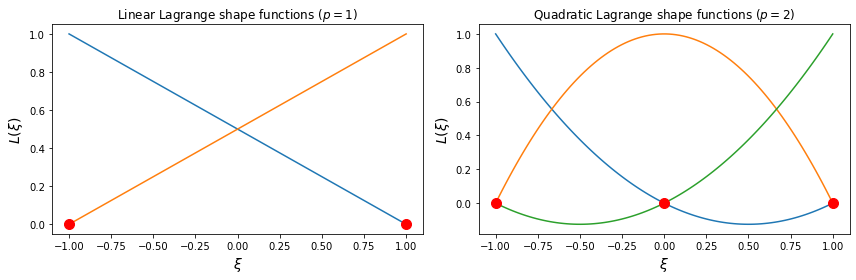

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# for dark theme aficionados (like me)
#plt.style.use('dark_background')

xi = np.linspace(-1,1,100)
L11 = (1-xi)/2; L21 = (1+xi)/2
L12 = -xi*(1-xi)/2; L22 = (1-xi)*(1+xi); L32 = xi*(1+xi)/2

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), tight_layout=True)
ax[0].plot(xi, L11, xi, L21); ax[0].plot([-1,1], [0,0], marker="o", color="red", linestyle='none', markersize=10)
ax[0].set(xlabel=r'$\xi$', ylabel=r'$L(\xi)$',
       title='Linear Lagrange shape functions ($p=1$)')
ax[1].plot(xi, L12, xi, L22, xi, L32); ax[1].plot([-1,0,1], [0,0,0], marker="o", color="red", linestyle='none', markersize=10)
ax[1].set(xlabel=r'$\xi$', ylabel=r'$L(\xi)$',
       title='Quadratic Lagrange shape functions ($p=2$)')

plt.show()


The Lagrange shape functions are the usual Finite Element shape functions. They have a very nice property, which is that *only one* shape function is active at a node (shown in red), all the others vanish. in maths terms, they are said to be **interpolatory**. This means that a given *degree of freedom* also corresponds to the solution value at a node of the mesh, which is very handy. 
On the other hand when we go from $p=1$ to $p=2$, all the shape functions are modified. 


In high-order FEM, another set of shape functions are used, the so-called **integrated Legendre polynomials**, also referred to as the **Lobatto** shape functions.

$l_q(\xi) = \sqrt{\frac{2q-1}{2}} \int_{-1}^{\xi} L_{q-1}(s) ds \quad$ with $q=2,3,\ldots,p$

where $L_{q}$ is the Legendre polynomial of order $q$. Let's check what this basis looks like:


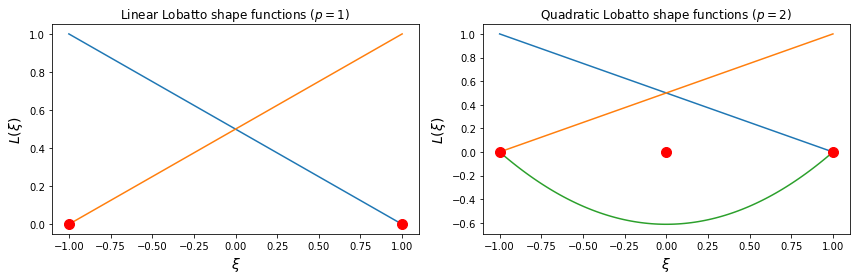

In [41]:
from ExternalFunctions import Lobatto as Lo

xi = np.linspace(-1,1,100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), tight_layout=True)

ax[0].plot(xi, Lo(xi,1)); ax[0].plot([-1,1], [0,0], marker="o", color="red", linestyle='none', markersize=10)
ax[0].set(xlabel=r'$\xi$', ylabel=r'$L(\xi)$',
       title='Linear Lobatto shape functions ($p=1$)')
ax[1].plot(xi, Lo(xi,2)); ax[1].plot([-1,0,1], [0,0,0], marker="o", color="red", linestyle='none', markersize=10)
ax[1].set(xlabel=r'$\xi$', ylabel=r'$L(\xi)$',
       title='Quadratic Lobatto shape functions ($p=2$)')
plt.show()


Interestingly, the Lobatto and Lagrange shape functions are equivalent for $p=1$, however for higher orders, they start to differ. 

The associated degrees of freedom do not correspond to the solution at speciﬁc points on the element (they are not interpolatory anymore). However, these shape functions are **hierarchic**, which means that the ﬁnite element basis of degree $p$  is obtained as a *correction* to the basis of degree $p-1$. This can be seen if plotting the basis for up to order 6. 
The linear shape functions are still present. 

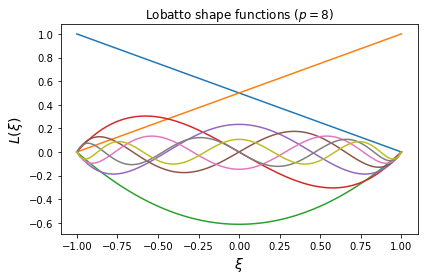

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), tight_layout=True)
ax.plot(xi, Lo(xi,8)); 
ax.set(xlabel=r'$\xi$', ylabel=r'$L(\xi)$',
       title='Lobatto shape functions ($p=8$)')
plt.show()

In short we can say that 
- Lagrange shape functions are **nodal** 
- Lobatto shape functions are **modal** 


Loosing the nodal property comes at a price, however being modal/hierarchic comes also with advantages, as it allows for local variations of the order across the mesh. 


On the quadrangle element in 2D, the basis can be obtained using a simple tensorization of the 1D shape functions, leading to a total of $(p+1)^2$ shape functions, as follows




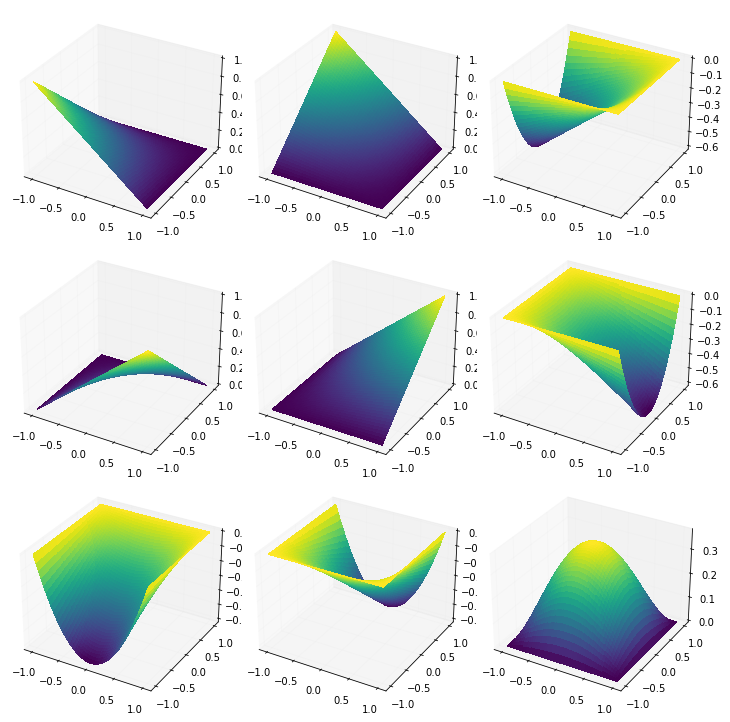

In [43]:
NrOfPoints = 50
Order = int(2)
xi = np.linspace(-1,1,NrOfPoints); eta = np.linspace(-1,1,NrOfPoints)
XI, ETA = np.meshgrid(xi,eta)
ShapeFunction1D_xi = Lo(XI.flatten(),Order)
ShapeFunction1D_eta = Lo(ETA.flatten(),Order);

fig = plt.figure(figsize=(10, 10), tight_layout=True)

index = 0
for i in np.arange(Order+1):
    for j in np.arange(Order+1):
        index += 1
        ShapeFunction2D = ShapeFunction1D_xi[:,i]*ShapeFunction1D_eta[:,j]
        ShapeFunction2D = ShapeFunction2D.reshape((NrOfPoints, NrOfPoints))        
        ax = fig.add_subplot(Order+1, Order+1, index, projection='3d')
        plt.rcParams['grid.color'] = (0.9, 0.9, 0.9, 0.2)
        #ax.set_axis_off()
        surf = ax.plot_surface(XI, ETA, ShapeFunction2D, rstride=1, cstride=1, cmap=cm.viridis,
                               linewidth=0, antialiased=False)

        
        

The approximation basis associated with each element is not limited to linear vertex functions, but is enriched with the so-called **edge** and **bubble** shape functions (face shape functions also appear on 3D elements). 

"Knitting together" two elements with two different orders along an edge becomes quite natural. Say first element is order $p=1$ and second element is $p=2$. Then one only has to *upgrade* the lower order element with a quadratic edge shape function  on that edge to ensure continuity  (which means that no shape function is *hanging* in the basis). This is called the maximum conformity rule, which is quite often used.  

Legendre polynomials are orthogonal w.r.t. the $L^2(-1,1)$ inner product, which means that the integral projection of a Legendre shape function on another one is null. The Lobatto shape functions on the other hand are orthogonal w.r.t. the $H^1(-1,1)$ inner product. This property has the benefit of improving the conditioning of the stiffness matrix for elliptic problems (see [Solin et al., 2008](https://www.taylorfrancis.com/books/mono/10.1201/9780203488041/higher-order-finite-element-methods-pavel-solin-karel-segeth-ivo-dolezel)).

Bubble shape functions are also interesting as their trace is zero on the boundary of the element. They can therefore be statically condensed out at the element level and removed from the ﬁnal system, which allows to reduce the memory footprint of the method (see [Lieu et al, 2017](https://doi.org/10.1016/j.jcp.2016.05.045)).

## The code

In this section, we will run a Finite element solution using high-order shape functions. 

Here are the parameters of the problem:

In [44]:
from ExternalFunctions import Mesh1D, CreateDofs
from ExternalFunctions import MassAndStiffness_1D
import math

# parameters of the problem
omega = 2*math.pi
rho0 = 1; c0 = 1;

# mesh and order
NrOfElem = 5
DuctLength = 4
Order = 5

rho_0 = 1; c0 = 1; # normalized fluid properties
beta = 1; Vn = 1/(rho_0*c0); # boundary conditions

Do not hesitate to update the parameters above to examine how the solution evolves for varying mesh size $h$, order $p$ and duct length. An important non-dimensional quantity to keep in mind while discretizing waves on a gird is the so-called *number of degrees of freedom per wavelength*. For $p$-FEM the formula reads

$d_\lambda = \frac{2\pi}{kh} p$

it indicates the resolution rate. There is a hard limit, even the most powerful numerical method is bound to the so-called "Nyquist " criterion, which states that a minimum of 2 degrees of freedom (two independent coefficients) are required to model unambiguously a wavelength. 


In [45]:
h = DuctLength/NrOfElem
d_lambda = 2*math.pi/(omega/c0*h)*Order
print('^' *100 +'\n'+' resolution rate is %1.4g' %d_lambda + ' dofs per wavelength\n' +'^' *100)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 resolution rate is 6.25 dofs per wavelength
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [46]:

# Let us now perform the numerical simulation for these inputs 

# first create the mesh and the Dofs list
NrOfNodes, Coord, Element = Mesh1D(DuctLength,NrOfElem)
NrOfDofs, DofNode, DofElement = CreateDofs(NrOfNodes,NrOfElem,Element,Order)

Matrix = np.zeros((NrOfDofs,NrOfDofs), dtype=np.complex128)
Rhs = np.zeros((NrOfDofs,1), dtype=np.complex128)
for iElem in np.arange(0,NrOfElem):
    # call the function returning the mass and stifness element matrices
    Ke, Me = MassAndStiffness_1D(iElem, Order, Coord, Element)
    ElemDofs = (DofElement[:,iElem]).astype(int)
    # assemble - [side note "irregular slice" requires np.ix_ in python]
    Matrix[np.ix_(ElemDofs,ElemDofs)] += Ke - (omega/c0)**2*Me

# now apply impedance boundary condition at last node
Matrix[DofNode[NrOfNodes-1],DofNode[NrOfNodes-1]] += 1j*omega/c0*beta

# and the velocity at first node 
Rhs[DofNode[0]] = 1j*omega*rho0*Vn

# solve the sparse system of equations 
Sol = np.linalg.solve(Matrix, Rhs) 

With this we obtained the numerical solution. By contrast to standard (nodal) finite elements, an additional step is required, because the solution vector does not represent the solution at nodes, only participation of modal shape functions. Also, with high-order methods, usually the original mesh is too coarse, and a subgrid is necessary for a good visualization.

Let's create that subgrid, interpolate the solution on it and then plot the solution to compare it to the reference solution $u_{\text{exact}}=e^{-ikx}$

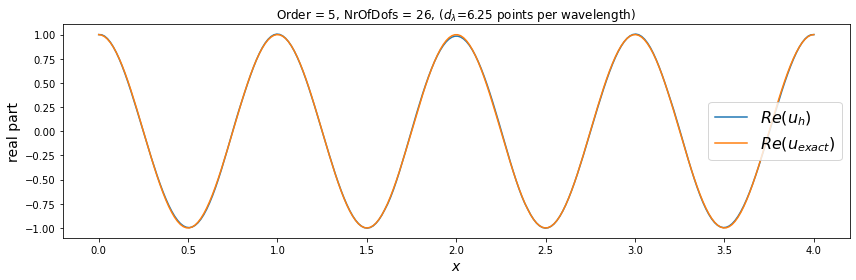

In [47]:
from ExternalFunctions import GetSolutionOnSubgrid

# compute the solution on a subgrid 
x_sub, u_h_sub = GetSolutionOnSubgrid(Sol, Order, Coord, Element, NrOfElem, DofElement)
# exact solution on subgrid 
u_exact_sub = np.exp(-1j*omega/c0*x_sub)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), tight_layout=True)
ax.plot(x_sub, np.real(u_h_sub), label="$Re(u_h)$") 
ax.plot(x_sub, np.real(u_exact_sub), label="$Re(u_{exact})$") 
ax.legend(loc="best",fontsize=16)
ax.set(xlabel=r'$x$', ylabel=r'real part', 
       #title='NrOfElem = '+str(NrOfElem)+', Order = '+str(Order)+', NrOfDofs = '+str(NrOfDofs) + ', ($d_\lambda$=%1.4g' %d_lambda +' points per wavelength)')
       title= 'Order = '+str(Order)+', NrOfDofs = '+str(NrOfDofs) + ', ($d_\lambda$=%1.4g' %d_lambda +' points per wavelength)')
plt.rc('axes', labelsize=16)
plt.show()

The (relative) error in percent on the subgrid nodes can then be computed as 

$E_2 = \left| u_h - u_{exact} \right|_2 / \left| u_{exact} \right|_2 \times 100$

We obtain

In [48]:
E2 = np.linalg.norm(u_h_sub - u_exact_sub)/np.linalg.norm(u_exact_sub)*100
print('-' *100 +'\n'+' Numerical error is %1.4g' %E2 + ' % \n' +'-' *100)

----------------------------------------------------------------------------------------------------
 Numerical error is 1.015 % 
----------------------------------------------------------------------------------------------------


It is now also interesting to plot the underlying shape functions (the *basis*) which allowed us to reach this result. 

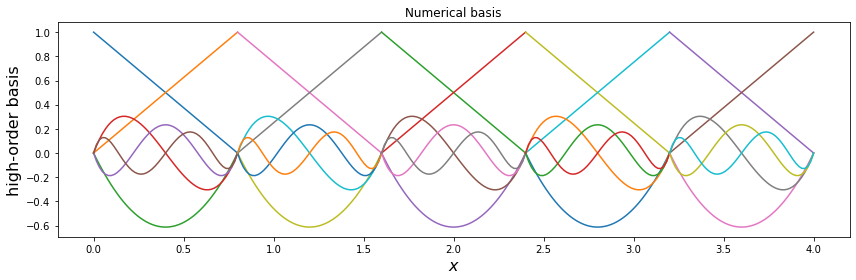

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), tight_layout=True)
for iElem in np.arange(0,NrOfElem):
    x_nodes = Coord[Element[0: 2, iElem].astype(int)]
    xi = np.linspace(-1,1); N1 = (1-xi)/2; N2 = (1+xi)/2; 
    x = N1*x_nodes[0] + N2*x_nodes[1]
    ax.plot(x, Lo(xi,Order))  
ax.set(xlabel=r'$x$', ylabel=r'high-order basis', title='Numerical basis')
plt.show()


# Plotting the convergence

With this simple code it is now possible to examine how fast the solution convergences for the different parameters. We grouped all previous operations in one function "ComputeFullSolution" that we will call, to then plot the error as a function of the resolution rate $d_\lambda$ for varying orders

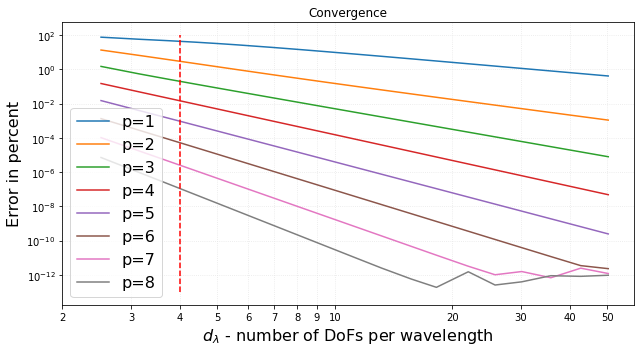

In [50]:
from ExternalFunctions import ComputeFullSolution
import matplotlib

omega = 10
DuctLength = 1
c0 = 1; rho0 = 1; beta = 1; Vn = 1/(rho_0*c0);

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5), tight_layout=True)

ORDER = np.arange(1,9)
RATE =  np.logspace(np.log10(2),np.log10(50),20)
ERROR_TABLE = np.zeros((RATE.size))
DLAMBDA_TABLE = np.zeros((RATE.size))
for Order in ORDER:
    mesh_index = -1
    for d_lambda in RATE:
        mesh_index += 1
        h = 2*math.pi/d_lambda/omega/c0
        #print('h=' + str(h))
        NrOfElem = np.ceil(DuctLength/h).astype(int)
        #print(NrOfElem)
        E2, NrOfDofs = ComputeFullSolution(DuctLength,NrOfElem,Order,omega,rho0,c0,Vn,beta)
        ERROR_TABLE[mesh_index] = E2
        DLAMBDA_TABLE[mesh_index] = 2*math.pi/(omega/c0*(DuctLength/NrOfElem))
    
    ax.plot(DLAMBDA_TABLE, ERROR_TABLE,label="p=%i" %Order)

ax.set(xlabel=r'$d_\lambda$ - number of DoFs per wavelength', ylabel=r'Error in percent', title='Convergence', yscale='log',xscale='log')
ax.grid(True, linestyle=":",which="both", axis="both")
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
ax.plot([4,4],[1e-13,100],"r--")
ax.xaxis.set_ticks([2,3,4,5,6,7,8,9,10,20,30,40,50]) 
ax.xaxis.set_ticklabels([2,3,4,5,6,7,8,9,10,20,30,40,50])
ax.legend(loc="best",fontsize=16)
plt.show()

For a fixed resolution rate, say $d_\lambda =4$ (shown with a dashed red line in previous figure), the relative error is orders of magnitude lower for higher-orders. Classical linear elements require a high resolution rate to reach a good accuracy.


## A bit of theory 

It can be shown that the $L_2$ error for the FEM applied to the Helmholtz equation is composed of two terms

$E_2 \approx \color{blue}{C_1 d_\lambda^{-p+1}} + \color{red}{C_2 \, kL \, d_\lambda^{-(2p+1)}}$


- The first term in this expression represents the <font color='blue'>interpolation error</font>, that dominates when the problem is well solved. It has a convergence of order with respect to the number of degrees of freedom per wavelength. This is a classical finite element error, present for thermal or elasticity problems as well. 
- The second term is associated with the <font color='red'>dispersion error</font>. Phase delay build up as the wave propagates and dispersion error will typically dominate for large values of $kL$ (referred to as the pollution effect, see [Babuska, 2000](https://doi.org/10.1137/S0036142994269186). This error is not found for all problems, it is in fact typical of *wave propagation* problems. 

The superiority of $p$-FEM (i.e. fixed mesh, order refinement) over $h$-FEM (i.e. fixed order, mesh refinement) is clear from this theoretical result.
While the convergence is only algebraic in $h$ (mesh refinement) it is exponential in $p$ (increasing order). For a constant number of dofs more accurate results are therefore typically obtained using high-order approximation. 

<img src="AccuracyAtSameRate.png" style="width:500px">

Standard low-order discretisation methods are therefore unable to solve wave problems at high wavenumbers, because they require a prohibitive computational effort in order to resolve the wave and control the pollution error.


In particular, resonance frequencies tend to be **overestimated**. Blue (linear FEM), Black (reference)

<img src="PollutionVisibleOnFRF.png" style="width:600px">

Important remarks:
- This theoretical result is valid only for smooth solutions. In the presence of singularities in the solution (i.e. in the vicinity of acoustic sources), $p$-refinement may become suboptimal and it is often recommended to  refine the mesh locally ($h$- refinement). However on "globally smooth" problems like encountered in acoustics, $p$-refinement is in most cases appropriate. 
- In 2D and 3D, the number of degrees of freedom is not necessarily a good indicator of the performance. Assembly costs, but also typical bandwidth and condition number of the resulting system matrix may also play an important role on the cost of a method. Experience however shows that, in spite of an increased bandwith, higher-order functions are beneficial for 3D Helmholtz problems when a direct solving procedure is used (see [Bériot et al., 2016](https://doi.org/10.1002/nme.5172)). 

- In real-life problems, the mesh is not necessarily uniform and it may be convenient to assign the orders automatically. *A-priori* error indicators can be designed for this purpose, which take into account the frequency, the mesh size and the medium properties, so as to guarantee a uniform resolution accross the full mesh.

Let's take an example. To define a non-uniform mesh, we used a functionality of the open source mesher [gmsh](https://gmsh.info/), which can read bitmaps and define grid density based on the pixel colors.

<img src="tintin.png" style="width:800px">

 Clear strong lines are present in the drawing (following la [Ligne claire](https://en.wikipedia.org/wiki/Ligne_claire), pioneered by Hergé, the Belgian cartoonist and creator of The Adventures of Tintin) which end up in strong mesh non uniformities. An error indicator assigns linear elements in these regions and higher order elements elsewhere so as to maintain a uniform repartition of the error across the mesh (see [Bériot & Gabard, 2019](https://doi.org/10.1016/j.jcp.2018.11.013)). 
 
This $p$-adaptive approach is leveraged in the commercial software [Simcenter 3D](https://www.plm.automation.siemens.com/global/en/products/simulation-test/acoustic-simulation.html) developped by Siemens, in a solver called FEMAO (FEM with adaptive order), dealing with large scale problems. The user does not have to worry too much about the resolution rate, as the effort is automatically adjusted across the domain, for each frequency. 